In [23]:
import os
import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm.notebook import tqdm

In [24]:
base = '../../Results/clusters_v1/'

all_files = [f"{base}clusters_{i}.csv" for i in range(10, 170)] 
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [25]:
# df['time'] = pd.to_datetime(df['time'])
# df['time'] = df['time'].apply(lambda dt: dt.replace(hour=12, minute=0, second=0)) # set time to noon, to match df_xr. Is daily average anyway

In [26]:
def calculate_persistency_stats(df, date_col='time', cluster_col='cluster_id'):
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Calculate the difference in days within each cluster
    df['date_diff'] = df.groupby(cluster_col)[date_col].diff().dt.days
    
    # Identify the start of a new streak
    df['new_streak'] = (df['date_diff'] != 1)
    
    # Create a new group identifier for each streak
    df['streak_id'] = df.groupby(cluster_col)['new_streak'].cumsum()
    
    # Calculate the length of each streak
    streak_lengths = df.groupby([cluster_col, 'streak_id']).size()
    
    # Calculate the average, median, standard deviation, and maximum persistency
    persistency_stats = streak_lengths.groupby(cluster_col).agg(['mean', 'median', 'std', 'max'])
    
    return persistency_stats, streak_lengths


In [27]:
def handle_deviations(df):
    df2 = df.copy()
    # Identify indices where date_diff is 2 and the next two date_diffs are 1
    indices = df.index[(df['date_diff'] == 2) & (df['date_diff'].shift(-1) == 1) & (df['date_diff'].shift(-2) == 1)]
    
    # Change the cluster_id for these indices to the cluster_id of the previous index
    for i in indices:
        df2.loc[i-1, 'cluster_id'] = df.loc[i-2, 'cluster_id']
    return df2

In [28]:
pers_stats, streak_lengths = calculate_persistency_stats(df)

In [29]:
# df2 = handle_deviations(df)

In [30]:
df['cluster_id']

0         3
1         3
2         3
3         3
4         3
         ..
143995    2
143996    2
143997    4
143998    4
143999    4
Name: cluster_id, Length: 144000, dtype: int64

(array([19375., 22684., 18607., 17650., 65684.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

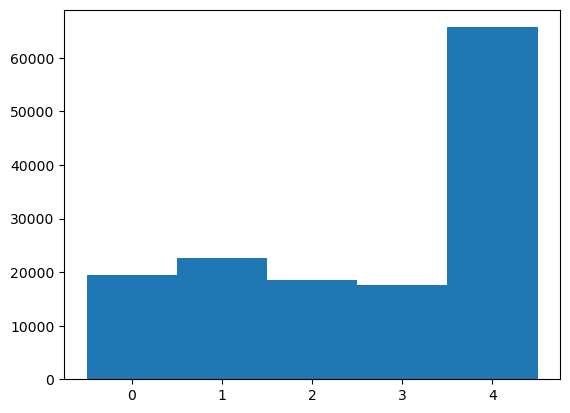

In [31]:
plt.hist(df['cluster_id'], bins = np.linspace(-.5, 4.5, 6))

Composites of regimes per run

In [10]:
PATH_anom = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_anomaly/"
PATH = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_d/"

In [11]:
run = 10
filename_anom = f"{PATH_anom}anom_zg500_d_ECEarth3_h{run:03d}.nc"
filename = f"{PATH}zg500_d_ECEarth3_h{run:03d}.nc"

ds = xr.open_dataset(filename_anom)
ds

<xarray.Dataset>
Dimensions:    (time: 3653, bnds: 2, lon: 257, lat: 128)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T09:00:00 ... 2009-12-31T09:00:00
  * lon        (lon) float64 -90.0 -89.3 -88.59 -87.89 ... 87.89 88.59 89.3 90.0
  * lat        (lat) float64 0.3509 1.053 1.754 2.456 ... 88.07 88.77 89.46
    plev       float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    zg500      (time, lat, lon) float32 ...
Attributes: (12/52)
    CDI:                                Climate Data Interface version 2.0.6 ...
    source:                             EC-Earth3 (2019): \naerosol: none\nat...
    institution:                        The Royal Netherlands Meteorological ...
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        CMIP
    branch_method:                      standard
    ...                                 ...
    variable_id:                        zg500
    variant_info:                       The p5 label refers to the fact that ...
    variant_label:                      r1i1p5f1
    license:                            The VAREX model data produced by KNMI...
    cmor_version:                       3.5.0
    CDO:                                Climate Data Operators version 2.0.6 ...

In [12]:
def plot_fromcluster(df, run, cluster):

    df_run = df[df['run'] == run]

    filename_anom = f"{PATH_anom}anom_zg500_d_ECEarth3_h{run:03d}.nc"
    filename = f"{PATH}zg500_d_ECEarth3_h{run:03d}.nc"

    ds = xr.open_dataset(filename_anom)
    ds_full = xr.open_dataset(filename)

    ds = ds.where(
        (ds['time'].dt.month.isin([12, 1, 2])) & 
        (ds['lon'] < 30) & 
        (ds['lat'] > 20) & 
        (ds['lat'] < 80), 
        drop=True
    )

    ds_full = ds_full.where(
        (ds_full['time'].dt.month.isin([12, 1, 2])) & 
        (ds_full['lon'] < 30) & 
        (ds_full['lat'] > 20) & 
        (ds_full['lat'] < 80), 
        drop=True
    )
    
    # for i in range(len(ds.time)):
    for i in range(50):
        cluster_id = df_run.loc[i, 'cluster_id']
        cluster_time = df_run.loc[i, 'time']
        
        if cluster_id != cluster:
            continue

        plt.figure(figsize=(10, 6))
        ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-30, central_latitude=50))

        vals = ds.sel(time = cluster_time).zg500.values
        vals_contour = ds_full.sel(time = cluster_time).zg500.values
        min_val = np.floor(np.min(vals_contour) / 100) * 100
        max_val = np.ceil(np.max(vals_contour) / 100) * 100

        levels = np.arange(min_val, max_val, 100)
        lons = ds.zg500['lon'].values
        lats = ds.zg500['lat'].values

        fill = ax.contourf(
            lons,
            lats,
            vals,
            levels = np.linspace(-200, 200, 41),
            cmap=plt.cm.RdBu_r,
            extend = 'both',
            transform=ccrs.PlateCarree())

        cs = ax.contour(
            lons,
            lats,
            vals_contour,
            levels = levels,
            transform = ccrs.PlateCarree(),
            colors = 'k'
        )

        ax.clabel(cs, inline=True, fontsize=10)

        cb = plt.colorbar(fill,
                        orientation='vertical',
                        label='500 hPa height anomaly [m]',
                        extend='both')
        ax.coastlines(resolution='50m')
        ax.set_title(f"Cluster {cluster_id} - Day {i}")
        ax.gridlines()
        plt.show()

In [13]:
def plot_animation(df, run):
    filename_anom = f"{PATH_anom}anom_zg500_d_ECEarth3_h{run:03d}.nc"
    filename = f"{PATH}zg500_d_ECEarth3_h{run:03d}.nc"

    ds = xr.open_dataset(filename_anom)
    ds_full = xr.open_dataset(filename)


    for i in range(20):
        cluster_id = df.loc[i, 'cluster_id']
        plt.figure(figsize=(10, 6))
        ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=45))

        vals = ds.isel(time = i).zg500.values
        vals_contour = ds_full.isel(time = i).zg500.values
        min_val = np.floor(np.min(vals_contour) / 100) * 100
        max_val = np.ceil(np.max(vals_contour) / 100) * 100

        levels = np.arange(min_val, max_val, 100)
        lons = ds.zg500['lon'].values
        lats = ds.zg500['lat'].values

        fill = ax.contourf(
            lons,
            lats,
            vals,
            levels = np.linspace(-200, 200, 41),
            cmap=plt.cm.RdBu_r,
            extend = 'both',
            transform=ccrs.PlateCarree())

        cs = ax.contour(
            lons,
            lats,
            vals_contour,
            levels = levels,
            transform = ccrs.PlateCarree(),
            colors = 'k'
        )

        ax.clabel(cs, inline=True, fontsize=10)

        cb = plt.colorbar(fill,
                        orientation='vertical',
                        label='500 hPa height anomaly [m]',
                        extend='both')
        ax.coastlines(resolution='50m')
        ax.set_title(f"Cluster {cluster_id} - Day {i}")
        ax.gridlines()
        plt.show()

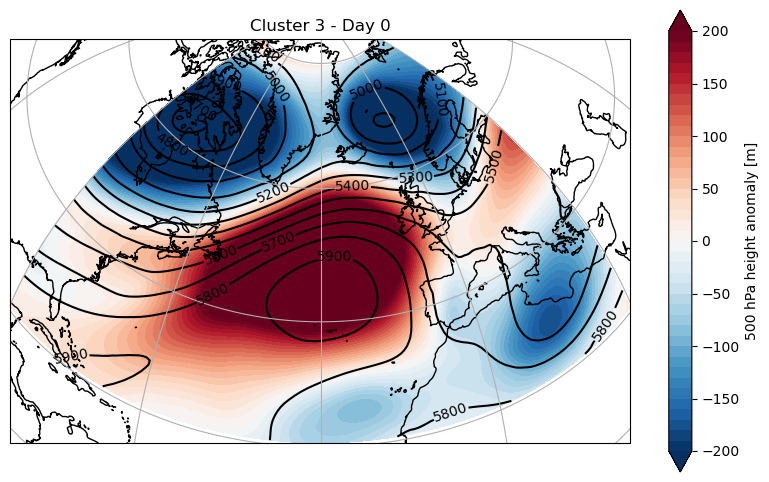

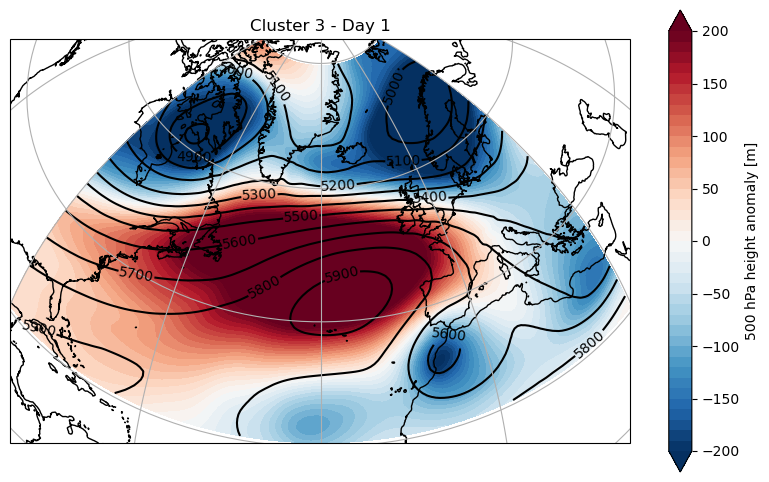

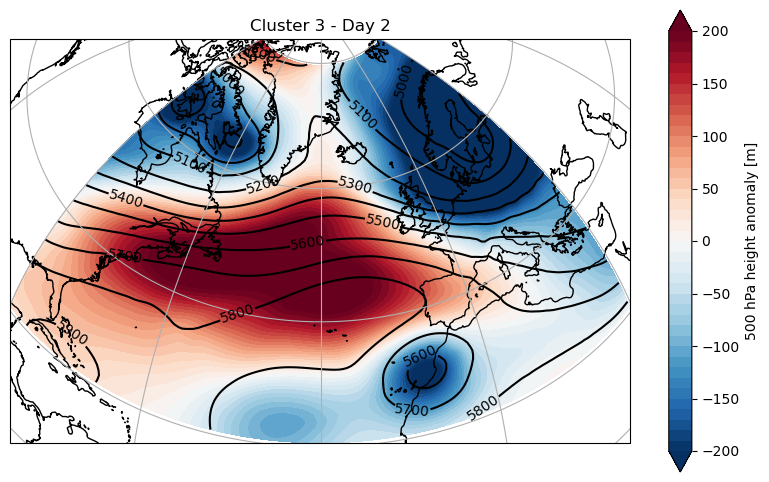

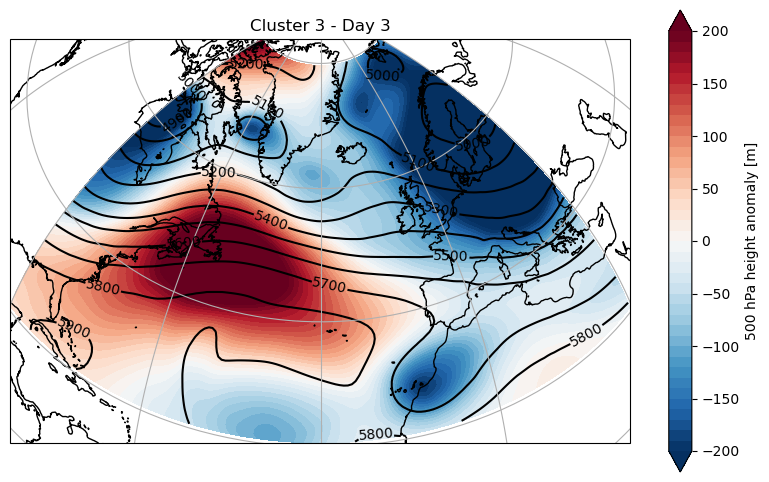

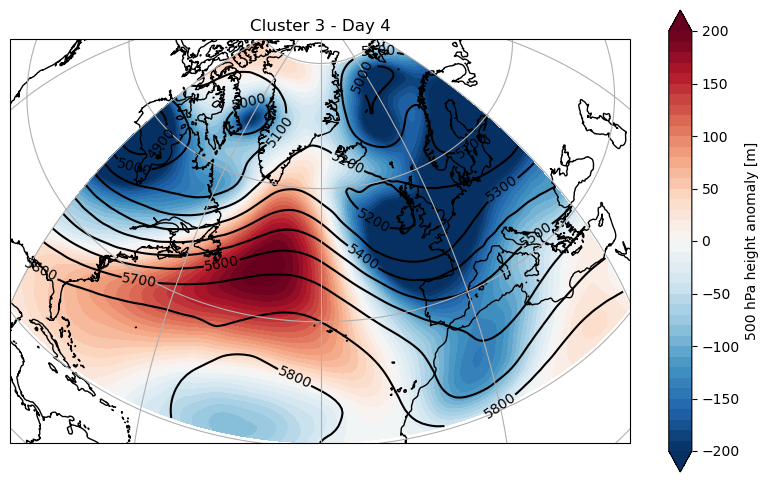

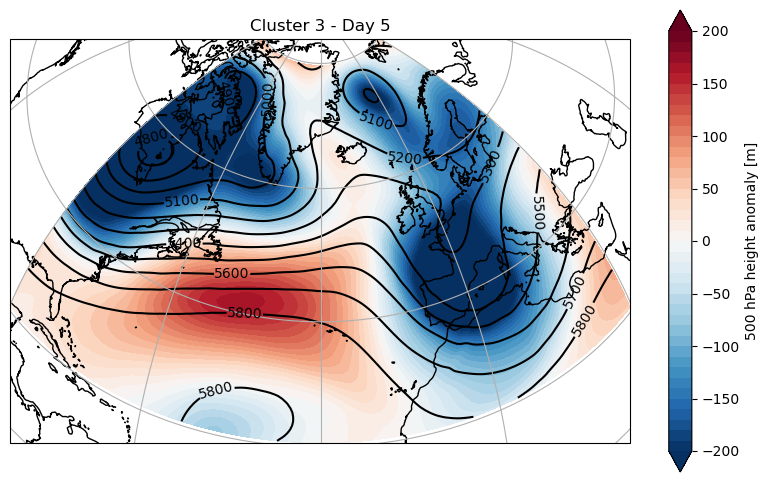

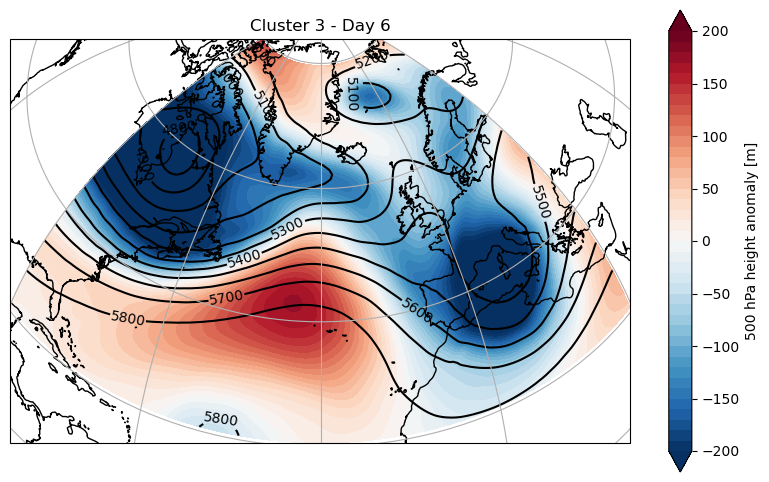

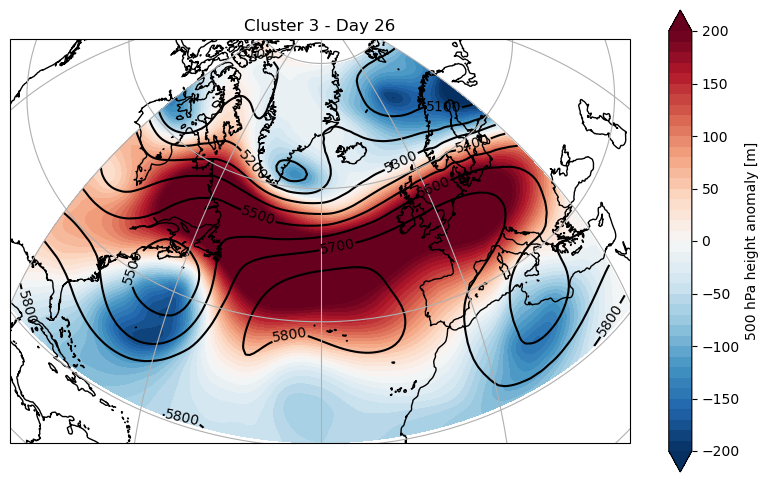

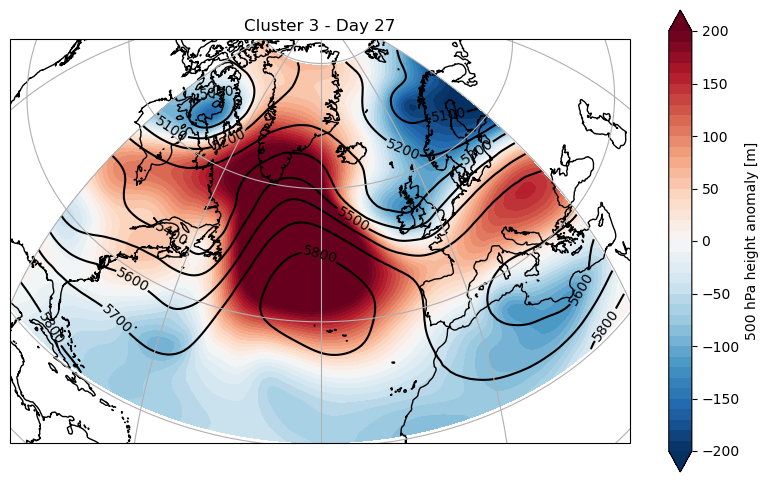

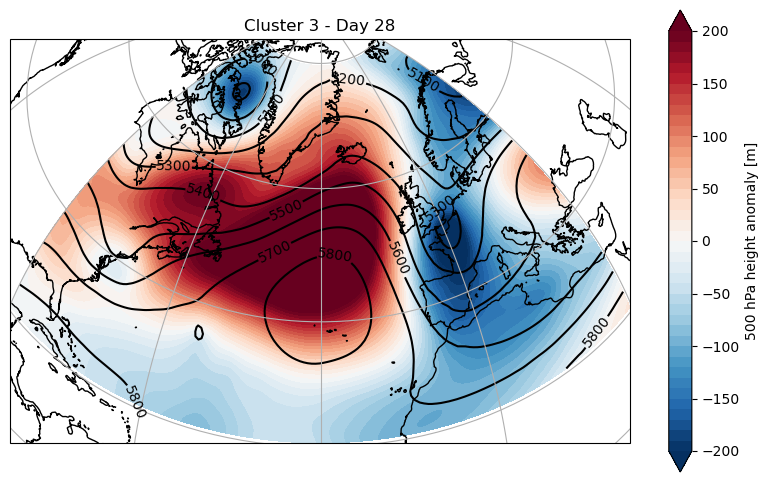

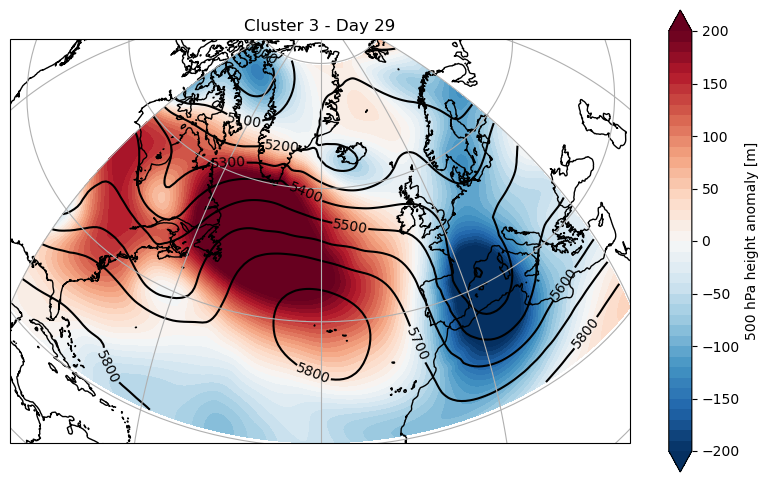

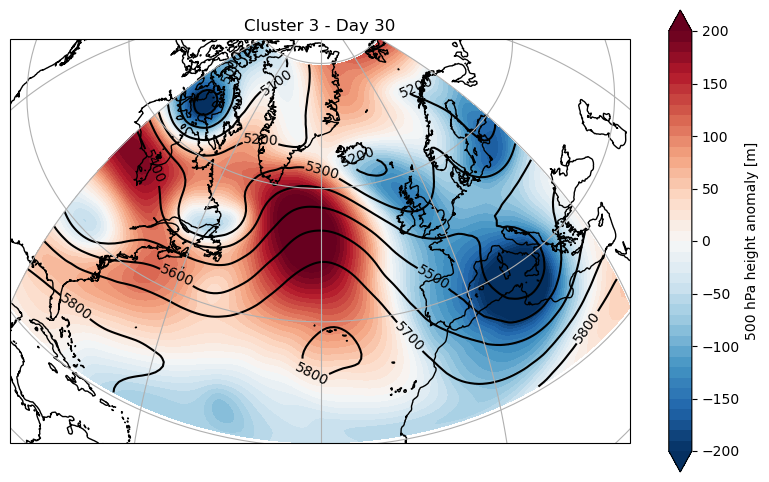

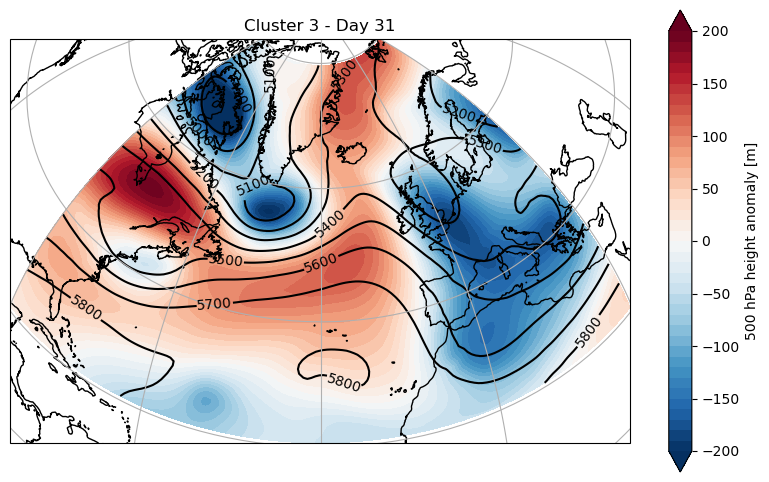

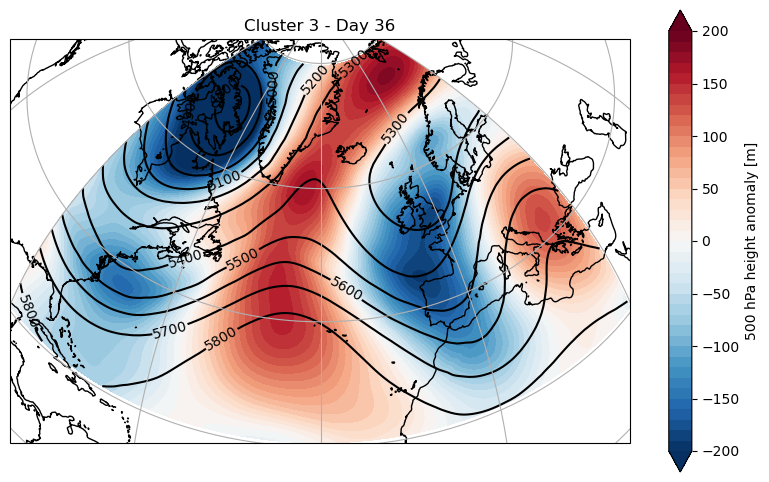

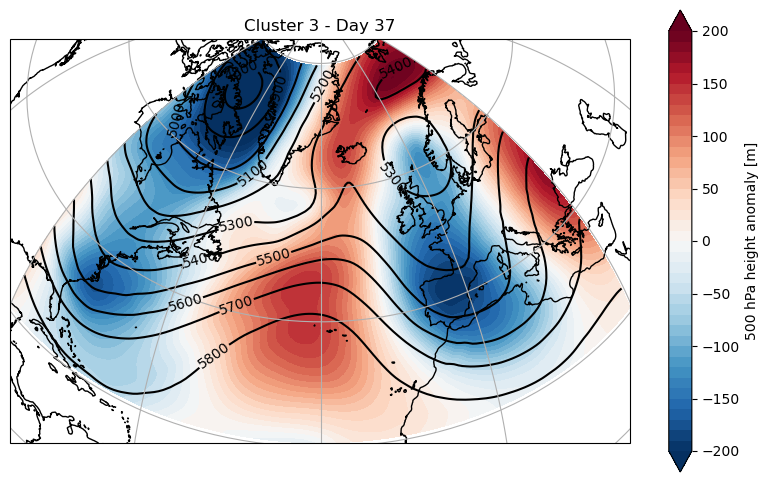

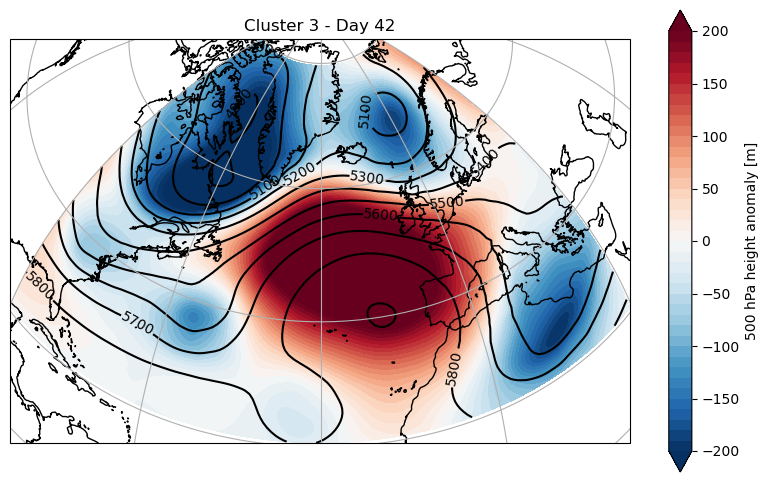

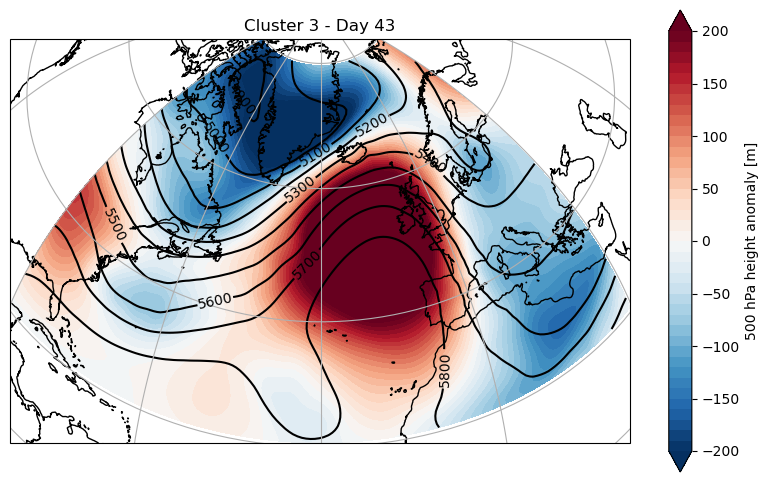

In [14]:
plot_fromcluster(df, 10, 3)

In [15]:
plot_fromcluster(df, 10, 4)

In [16]:
def plot_clustering(df, run, cluster_id):
    mask = (df['run'] == run) & (df['cluster_id'] == cluster_id)
    times = df.loc[mask, 'time']

    filename_anom = f"{PATH_anom}anom_zg500_d_ECEarth3_h{run:03d}.nc"
    filename = f"{PATH}zg500_d_ECEarth3_h{run:03d}.nc"
    ds = xr.open_dataset(filename_anom)
    ds_full = xr.open_dataset(filename)

    ds = ds.where(
        (ds['time'].dt.month.isin([12, 1, 2])) &
        (ds['lon'] < 30) &
        (ds['lat'] > 20) &
        (ds['lat'] < 80),
        drop=True
    )

    ds_full = ds_full.where(
        (ds_full['time'].dt.month.isin([12, 1, 2])) &
        (ds_full['lon'] < 30) &
        (ds_full['lat'] > 20) &
        (ds_full['lat'] < 80),
        drop=True
    )
    
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-30, central_latitude=50))

    vals = ds.sel(time = times.tolist()).zg500.mean(dim = 'time').values
    vals_contour = ds_full.sel(time = times.tolist()).zg500.mean(dim = 'time').values
    min_val = np.floor(np.min(vals_contour) / 100) * 100
    max_val = np.ceil(np.max(vals_contour) / 100) * 100

    levels = np.arange(min_val, max_val, 100)
    lons = ds.zg500['lon'].values
    lats = ds.zg500['lat'].values

    fill = ax.contourf(
        lons,
        lats,
        vals,
        levels = np.linspace(-200, 200, 41),
        cmap=plt.cm.RdBu_r,
        extend = 'both',
        transform=ccrs.PlateCarree())

    cs = ax.contour(
        lons,
        lats,
        vals_contour,
        levels = levels,
        transform = ccrs.PlateCarree(),
        colors = 'k'
    )

    ax.clabel(cs, inline=True, fontsize=10)

    cb = plt.colorbar(fill,
                    orientation='vertical',
                    label='500 hPa height anomaly [m]',
                    extend='both')
    ax.coastlines(resolution='50m')
    ax.gridlines()

In [17]:
def plot_all_clusters(df, run):
    fig, axs = plt.subplots(2, 2, figsize=(20, 12),
                            subplot_kw={'projection': ccrs.Orthographic(central_longitude=-30, central_latitude=50)})

    for i, ax in enumerate(axs.flat):
        cluster_id = i
        mask = (df['run'] == run) & (df['cluster_id'] == cluster_id)
        times = df.loc[mask, 'time']

        filename_anom = f"{PATH_anom}anom_zg500_d_ECEarth3_h{run:03d}.nc"
        filename = f"{PATH}zg500_d_ECEarth3_h{run:03d}.nc"
        ds = xr.open_dataset(filename_anom)
        ds_full = xr.open_dataset(filename)

        ds = ds.where(
            (ds['time'].dt.month.isin([12, 1, 2])) &
            (ds['lon'] < 30) &
            (ds['lat'] > 20) &
            (ds['lat'] < 80),
            drop=True
        )

        ds_full = ds_full.where(
            (ds_full['time'].dt.month.isin([12, 1, 2])) &
            (ds_full['lon'] < 30) &
            (ds_full['lat'] > 20) &
            (ds_full['lat'] < 80),
            drop=True
        )

        vals = ds.sel(time = times.tolist()).zg500.mean(dim = 'time').values
        vals_contour = ds_full.sel(time = times.tolist()).zg500.mean(dim = 'time').values
        min_val = np.floor(np.min(vals_contour) / 100) * 100
        max_val = np.ceil(np.max(vals_contour) / 100) * 100

        levels = np.arange(min_val, max_val, 100)
        lons = ds.zg500['lon'].values
        lats = ds.zg500['lat'].values

        fill = ax.contourf(
            lons,
            lats,
            vals,
            levels = np.linspace(-200, 200, 41),
            cmap=plt.cm.RdBu_r,
            extend = 'both',
            transform=ccrs.PlateCarree())

        cs = ax.contour(
            lons,
            lats,
            vals_contour,
            levels = levels,
            transform = ccrs.PlateCarree(),
            colors = 'k'
        )

        ax.clabel(cs, inline=True, fontsize=10)

        cb = plt.colorbar(fill,
                        orientation='vertical',
                        label='500 hPa height anomaly [m]',
                        extend='both',
                        ax=ax)
        ax.coastlines(resolution='50m')
        ax.gridlines()
        ax.set_title(f"Cluster {cluster_id}")

    plt.tight_layout()
    plt.show()


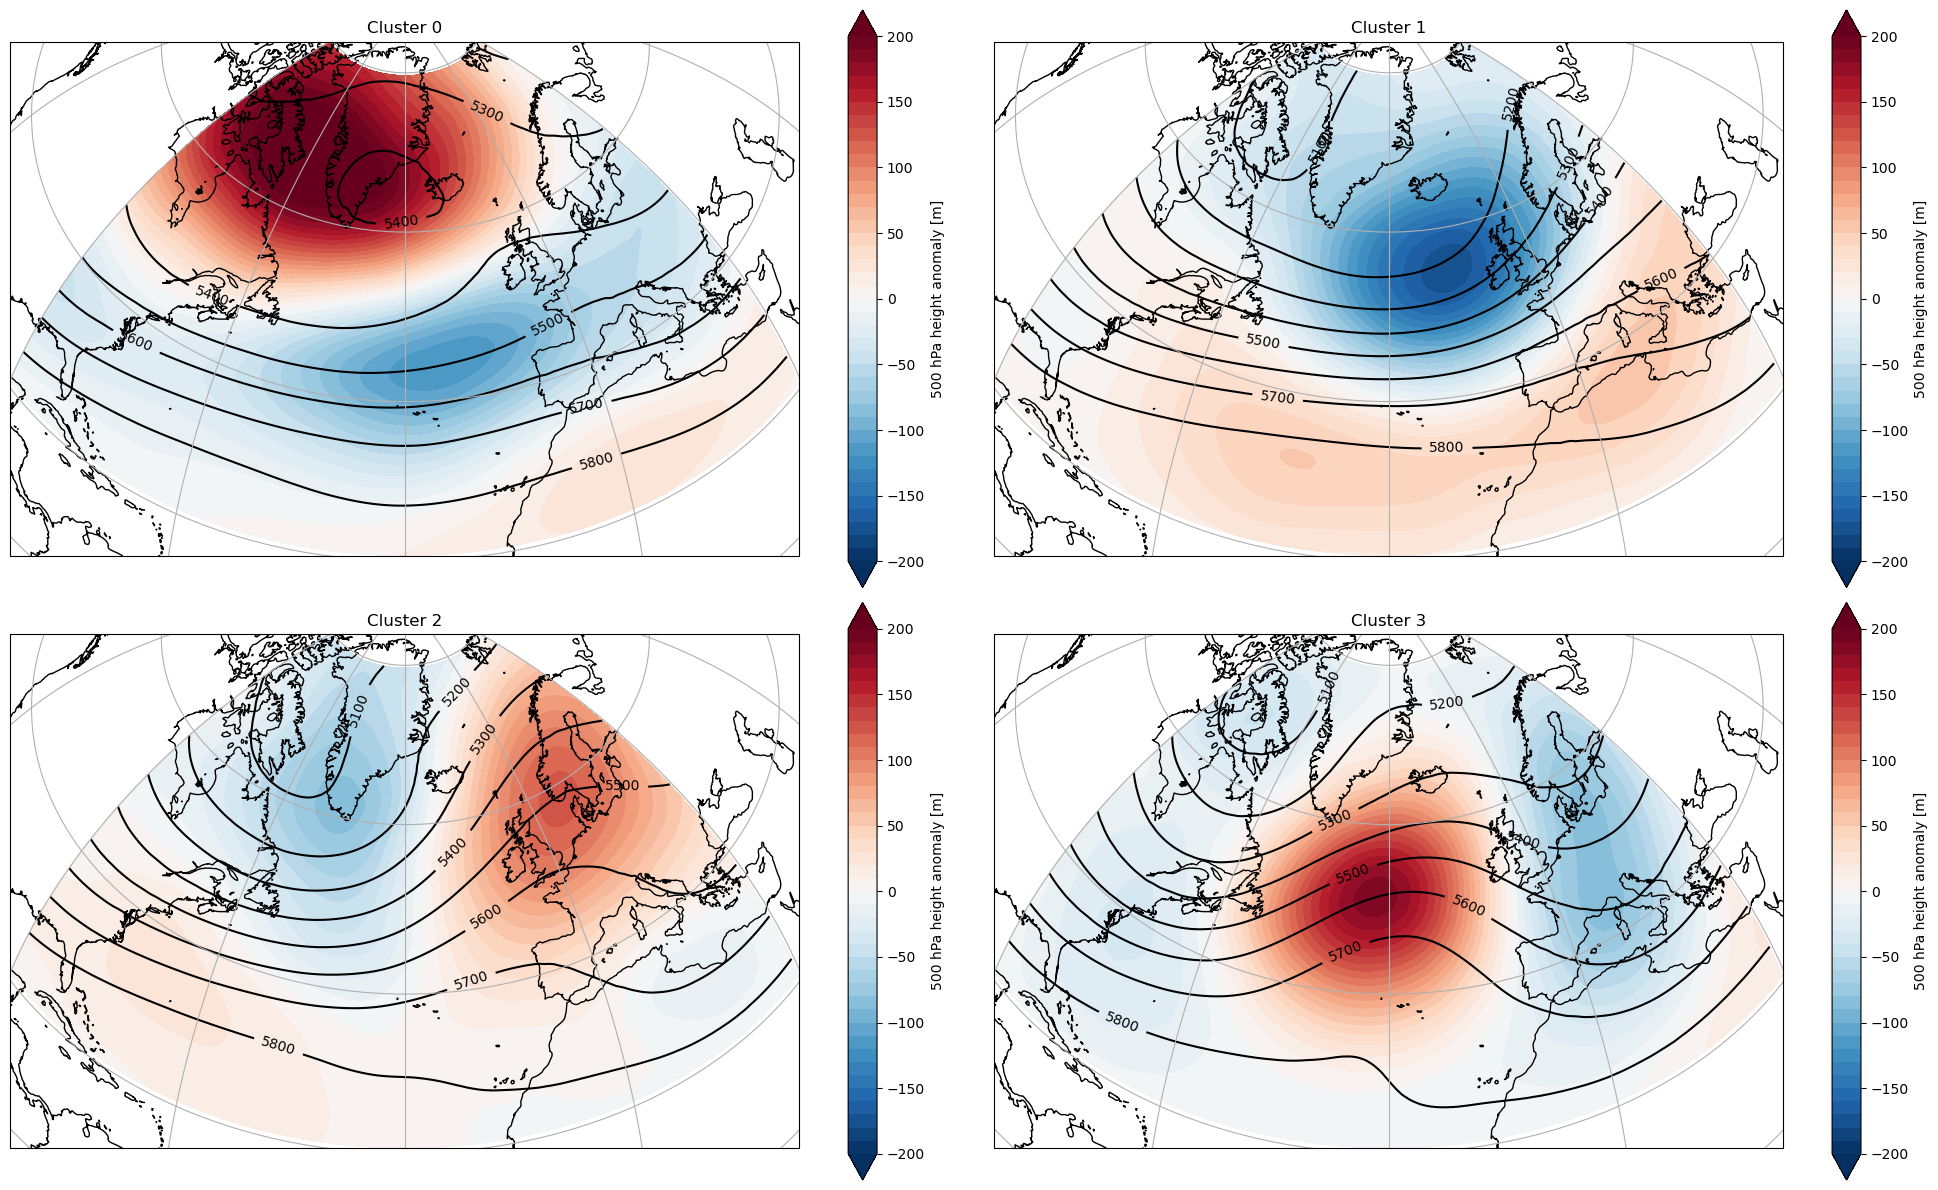

In [18]:
plot_all_clusters(df, 10)

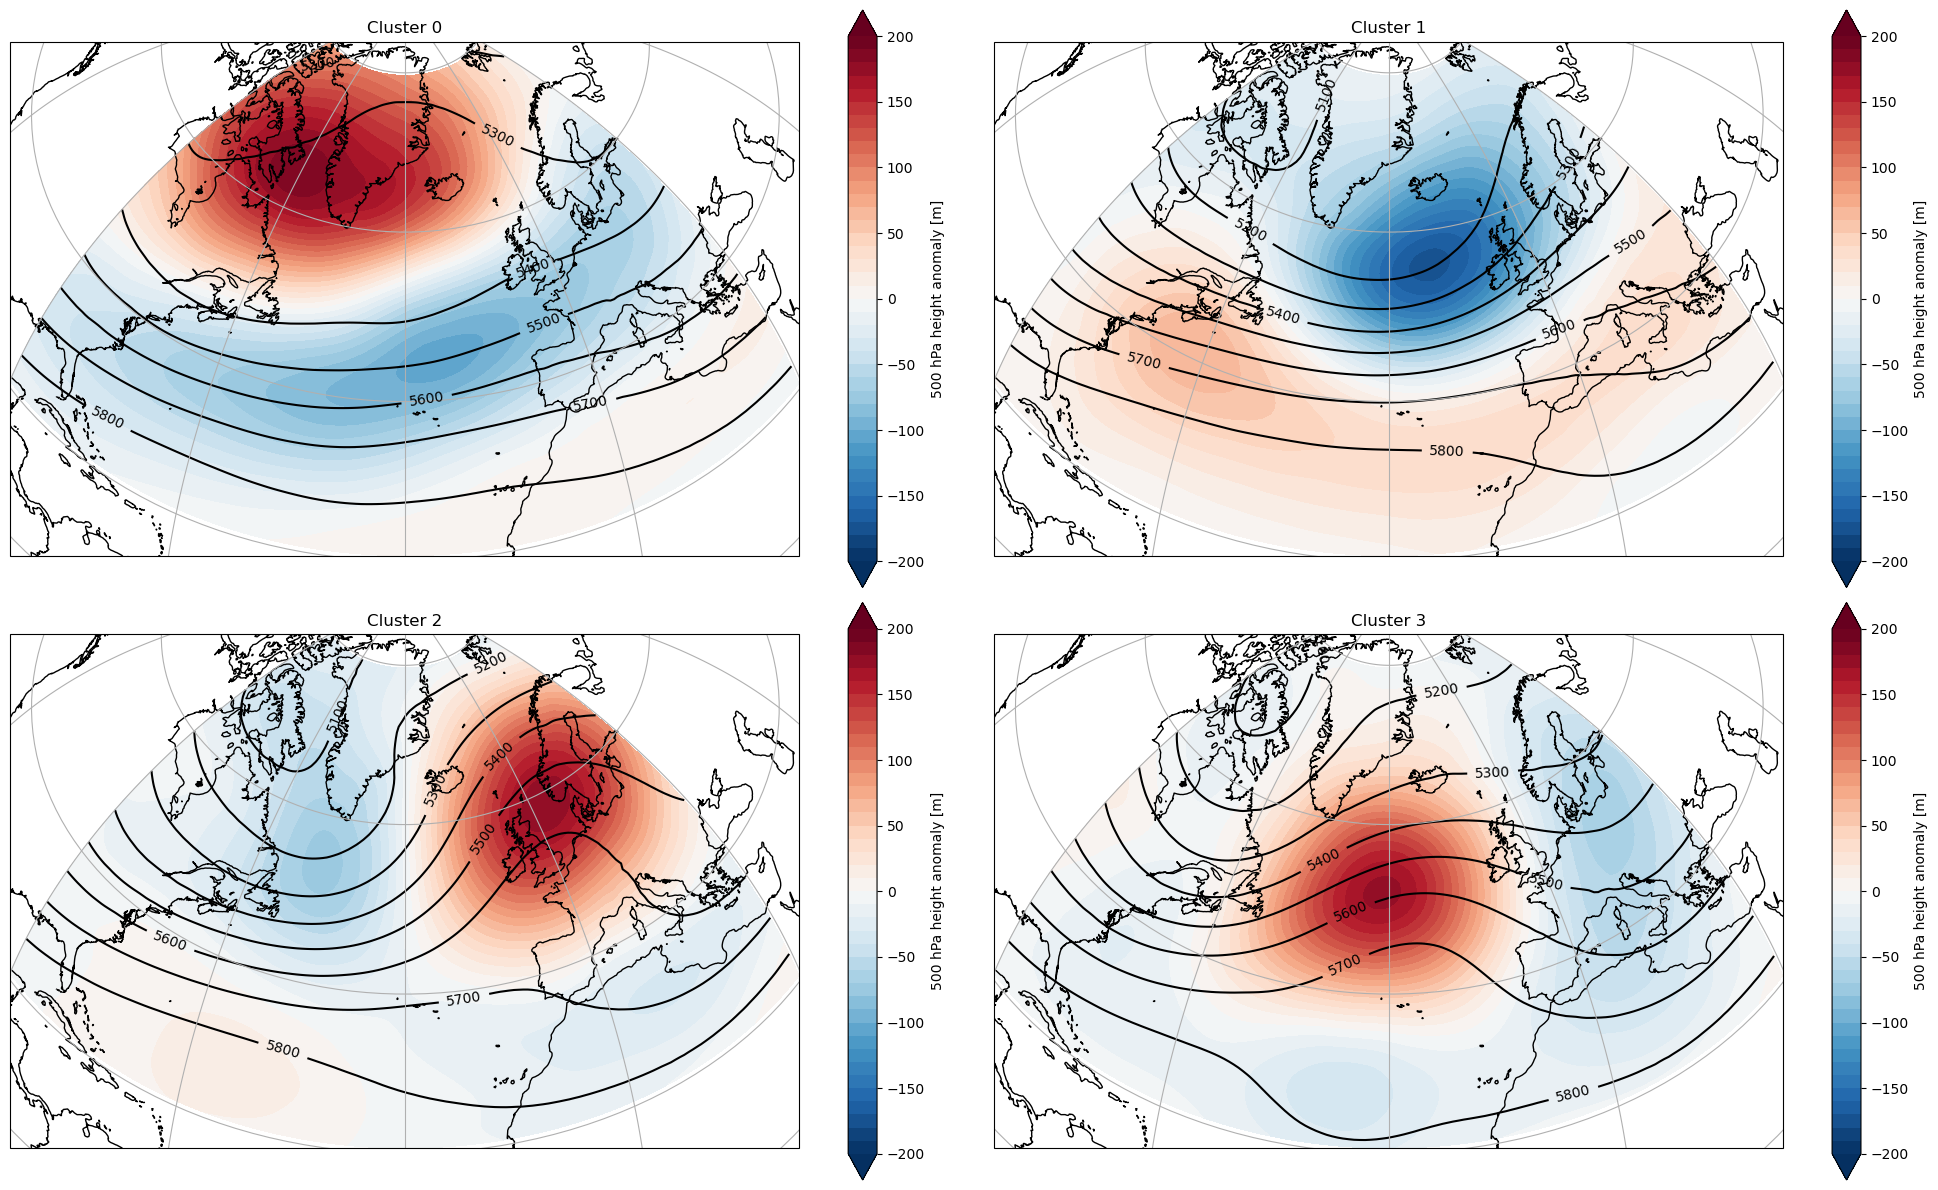

In [19]:
plot_all_clusters(df, 45)

Stack df, just a test

In [20]:
df.to_csv(f"../../Results/clusters_v1/clusters_all.csv")